#### Import packages

In [1]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random 

# pip install np_utils and then restart your terminal if you get error
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras import backend as K

Using TensorFlow backend.


In [2]:
# Helper function for loading slides
import os
from IPython.display import display as ipydisplay, Image, clear_output, HTML 

IMAGES_FOLDER = os.path.join('media') 

def show_image(name):
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

#### Setup training directory 

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Dataset directory
dataset_path = os.path.join(ROOT_DIR, "dataset/")
# Test images directory
test_images_path = os.path.join(ROOT_DIR, "test_images/")

In [4]:
# Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=48 # The images will be resized to 48x48 pixels

#### Helper functions

In [5]:
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()


#### Load training data

In [6]:
x_train = np.load("{}/x_train.npy".format(dataset_path))
y_train = np.load("{}/y_train.npy".format(dataset_path))

x_val = np.load("{}/x_val.npy".format(dataset_path))
y_val = np.load("{}/y_val.npy".format(dataset_path))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(57636, 96, 96, 3) (57636, 10) (14409, 96, 96, 3) (14409, 10)


#### Train, Validation and Test set

Usually, the trainining set is split up into `train` and `validation` set. The model is trained using the train set and the performance is evaluated using the validation set. If the performance is not satisfactory the model is tinkered to get a better performance on the validation data. In this way the model actually overfits on the validation set. To get an estimate of its performance on unseen data we use the `test` data. In theory, test data should not be used to modify model parameters.

In [7]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

57636 train samples
14409 validation samples


Resize training data to 48x48 pixels

In [7]:
x_train_rs = []

for i in x_train:
    i =cv2.resize(i,(RESIZE_DIM, RESIZE_DIM),interpolation=cv2.INTER_AREA)
    x_train_rs.append(i)
    
x_train_rs = np.array(x_train_rs)
x_train_rs.shape

(57636, 48, 48, 3)

Resize validation data to 48x48 pixels

In [8]:
x_val_rs = []

for i in x_val:
    i =cv2.resize(i,(RESIZE_DIM, RESIZE_DIM),interpolation=cv2.INTER_AREA)
    x_val_rs.append(i)
    
x_val_rs = np.array(x_val_rs)
x_val_rs.shape

(14409, 48, 48, 3)

#### Our final training and validation set

In [9]:
print(x_train_rs.shape, y_train.shape, x_val_rs.shape, y_val.shape)

(57636, 48, 48, 3) (57636, 10) (14409, 48, 48, 3) (14409, 10)


#### Let's see a sample

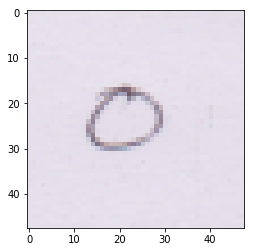

In [10]:
img = x_train_rs[5]
plt.imshow(img)

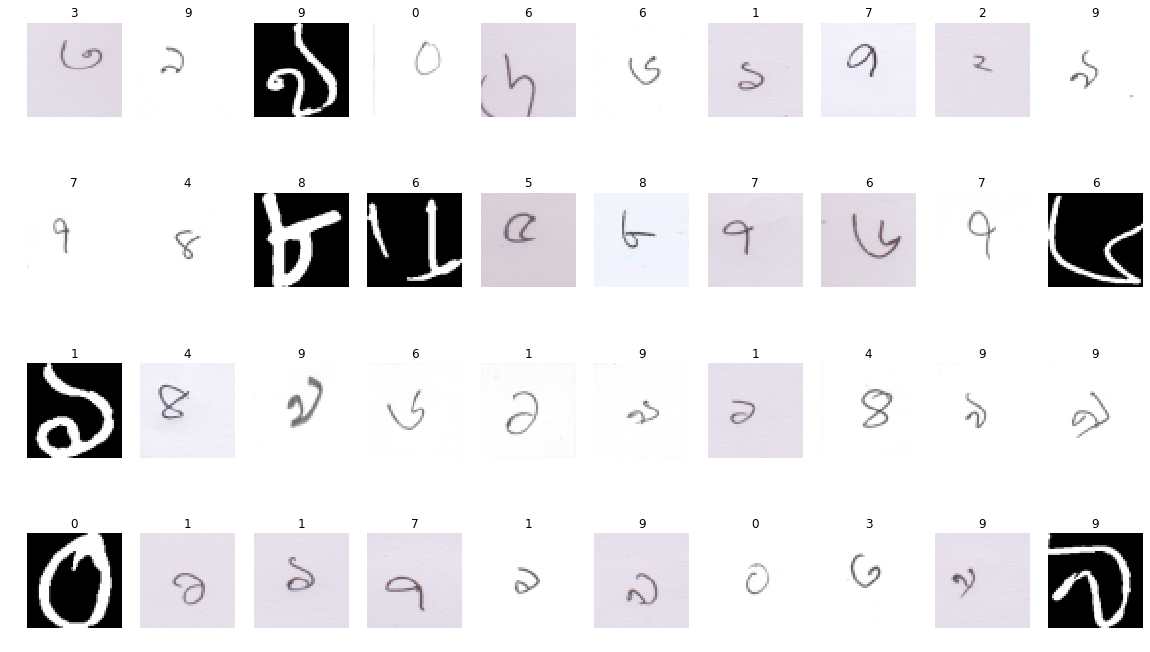

In [12]:
imshow_group(x_train_rs[-40:], y_train[-40:]) 

#### Preprocess entire training and validation data

In [13]:
x_train_rs = x_train_rs.astype('float32')
x_val_rs = x_val_rs.astype('float32')
x_train_rs /= 255
x_val_rs /= 255

print('x_train shape:', x_train_rs.shape)
print(x_train_rs.shape[0], 'train samples')
print(x_val_rs.shape[0], 'test samples')

x_train shape: (57636, 48, 48, 3)
57636 train samples
14409 test samples


# Model Architecture

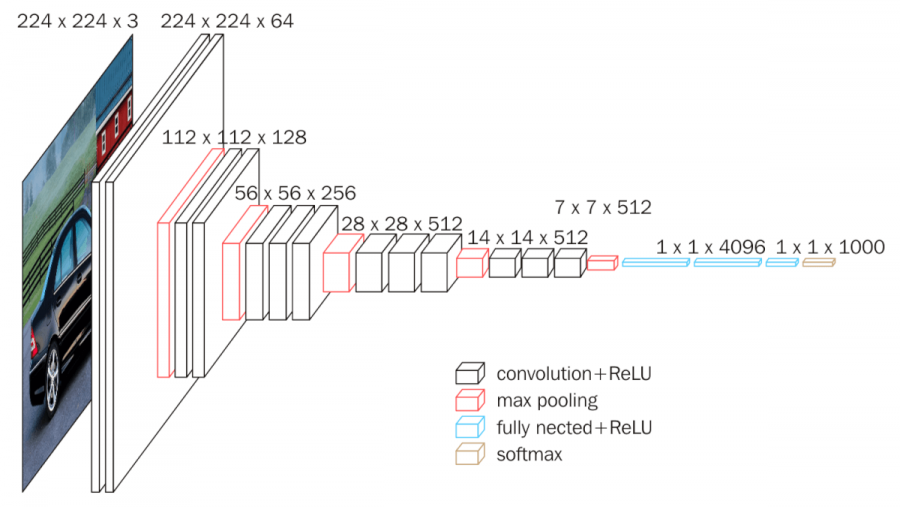

In [14]:
show_image("vgg.png")

Reference: https://arxiv.org/abs/1409.1556

In [11]:
# Conventional transfer learning
# model with ALL layers frozen, except for the SOFTMAX layer

def get_model_exp1_a():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(48, 48, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    predictions = Dense(10, activation='softmax')(X)
    
    # magical line of freezing layers
    for layer in base_model.layers:
        layer.trainable=False
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model=get_model_exp1_a()
model.summary()

W0625 22:19:42.725146 139779912189696 deprecation_wrapper.py:119] From /home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 22:19:43.059855 139779912189696 deprecation_wrapper.py:119] From /home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 22:19:43.137541 139779912189696 deprecation_wrapper.py:119] From /home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 22:19:43.205111 139779912189696 deprecation_wrapper.py:119] From /home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please us

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [13]:
model=get_model_exp1_a()

path_model='my_first_vgg.h5' # save model at this location after each epoch
K.set_value(model.optimizer.lr,1e-2) # set the learning rate

h=model.fit(x=x_train_rs,     
            y=y_train, 
            batch_size=32, 
            epochs=3, 
            verbose=1, 
            validation_data=(x_val_rs,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

W0625 22:20:10.114082 139779912189696 deprecation.py:323] From /home/hasib/anaconda3/envs/ieee/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 57636 samples, validate on 14409 samples
Epoch 1/3
  896/57636 [..............................] - ETA: 13:53 - loss: 13.7294 - acc: 0.0971

KeyboardInterrupt: 

to be continued....

In [14]:
def tensor_3to4(img):
    '''
    Resizes and expands dimension
    
    Input: img: a 3-channel image as input
    
    Returns a rank-4 tensor, since the network accepts batches of images
    One image corresponds to batch size of 1
    '''
    img = cv2.resize(img, (RESIZE_DIM, RESIZE_DIM))
    img_4d = np.expand_dims(img, axis=0)  # rank 4 tensor for prediction
    return img_4d

(96, 96, 3)


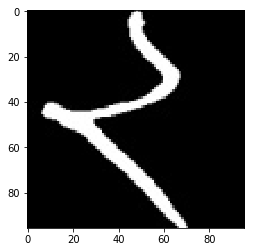

In [56]:
# Load a random image from the images folder
path_names = next(os.walk(test_images_path))[2]
image = cv2.imread(os.path.join(test_images_path, random.choice(path_names)))
print(image.shape)
plt.imshow(image)

#### Single image prediction

In [57]:
# Convert image to 4D tensor for inference
image = tensor_3to4(image)
# Run prediction
y_pred = model.predict(image)
# Convert probability prediction to predicted label
y = np.argmax(y_pred)
print("The image is: {}".format(y))

The image is: 2


#### Validation accuracy of 92%, can we do better?

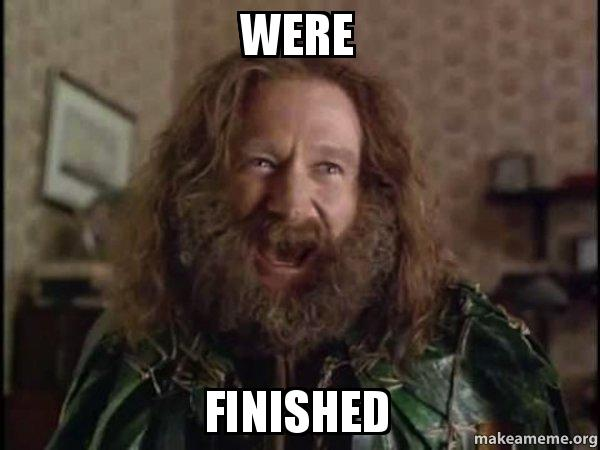

In [17]:
show_image("were-finished.jpg")

In [1]:
print("Done!")

Done!
